In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shap
import os
from sklearn.inspection import permutation_importance
import matplotlib.cm as cm
from xgboost import XGBRegressor, plot_importance
from statsmodels.api import OLS, add_constant
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-07-03 17:28:10.010218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751563690.220977      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751563690.283508      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
# Load the dataset from the provided file path
file_path = '/kaggle/input/ml-cfd/Final_CFD_ML_2.csv'

# Read the file to inspect its structure
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Re      186 non-null    int64  
 1   d       186 non-null    float64
 2   Sc      186 non-null    float64
 3   C       186 non-null    float64
 4   U       186 non-null    float64
 5   E       186 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 8.8 KB


(    Re    d   Sc         C         U         E
 0  100  0.1  0.5  0.118193  0.123010  0.075075
 1  100  0.1  0.6  0.115250  0.123010  0.075075
 2  100  0.1  0.7  0.113453  0.123010  0.075075
 3  100  0.1  0.8  0.112542  0.123011  0.075075
 4  100  0.1  0.9  0.112309  0.123011  0.075075,
 None)

In [3]:

# Define features and targets
features = df[['Re', 'd', 'Sc']]
targets = df[['C', 'U', 'E']]

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets for each target
X_train, X_test, y_train, y_test = train_test_split(features_scaled, targets, test_size=0.2, random_state=42)

# Separate targets for individual modeling
y_train_C = y_train['C']
y_test_C = y_test['C']

y_train_U = y_train['U']
y_test_U = y_test['U']

y_train_E = y_train['E']
y_test_E = y_test['E']

# Output summary of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Print the first few rows of X_train and X_test to verify the feature columns
features_list = ['Re', 'd', 'Sc']

print("X_train first few rows:")
for i, feature in enumerate(features_list):
    print(f"{feature}: {X_train[:5, i]}")

print("\nX_test first few rows:")
for i, feature in enumerate(features_list):
    print(f"{feature}: {X_test[:5, i]}")



X_train first few rows:
Re: [ 0.60228521  0.60228521  1.2989584  -1.34839972 -1.34839972]
d: [-0.24140394  0.90990716 -0.81705949  1.48556271 -0.24140394]
Sc: [ 0.29277002  0.29277002 -1.46385011 -0.87831007 -1.46385011]

X_test first few rows:
Re: [ 0.60228521  1.2989584   1.2989584  -0.09438798 -0.09438798]
d: [-1.39271504  0.33425161  0.90990716  0.90990716  0.90990716]
Sc: [ 1.46385011 -0.29277002 -0.87831007  1.46385011  0.87831007]


In [4]:
# Function to evaluate SVR
def evaluate_svr(X_train, X_test, y_train, y_test, target_name):

    # Define the SVR model with RBF kernel
    svr_rbf = SVR(kernel='rbf', C=50, gamma=0.1, epsilon=0.01)
    #svr_lin = SVR(kernel="linear", C=100, gamma="auto")
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)  # Make predictions
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    return mse, mae, r2, rmse, correlation, y_pred, svr_rbf

# Perform SVR evaluation for each target
metrics_C = evaluate_svr(X_train, X_test, y_train_C, y_test_C, "C")
metrics_U = evaluate_svr(X_train, X_test, y_train_U, y_test_U, "U")
metrics_E = evaluate_svr(X_train, X_test, y_train_E, y_test_E, "E")
#metrics_lift = evaluate_svr(X_train, X_test, y_train_lift, y_test_lift, "Lift")

# Print SVR results
# Optionally, print the model parameters or weights (if needed)
#print(mlp_model.coefs_)  # Coefficients (weights) of the neural network layers

print("SVR Results:")
print(f"C: MSE={metrics_C[0]:.4f}, MAE={metrics_C[1]:.4f}, R²={metrics_C[2]:.4f}, RMSE={metrics_C[3]:.4f}, Correlation={metrics_C[4]:.4f}")
print(f"U: MSE={metrics_U[0]:.4f}, MAE={metrics_U[1]:.4f}, R²={metrics_U[2]:.4f}, RMSE={metrics_U[3]:.4f}, Correlation={metrics_U[4]:.4f}")
print(f"E: MSE={metrics_E[0]:.4f}, MAE={metrics_E[1]:.4f}, R²={metrics_E[2]:.4f}, RMSE={metrics_E[3]:.4f}, Correlation={metrics_E[4]:.4f}")
#print(f"Lift: MSE={metrics_lift[0]:.4f}, MAE={metrics_lift[1]:.4f}, R²={metrics_lift[2]:.4f}, RMSE={metrics_lift[3]:.4f}, Correlation={metrics_lift[4]:.4f}")

SVR Results:
C: MSE=0.0001, MAE=0.0066, R²=0.9967, RMSE=0.0078, Correlation=0.9985
U: MSE=0.0006, MAE=0.0199, R²=0.9951, RMSE=0.0245, Correlation=0.9980
E: MSE=0.0001, MAE=0.0069, R²=0.7995, RMSE=0.0077, Correlation=0.9030



SHAP Explanation for C:


  0%|          | 0/38 [00:00<?, ?it/s]

The figure layout has changed to tight


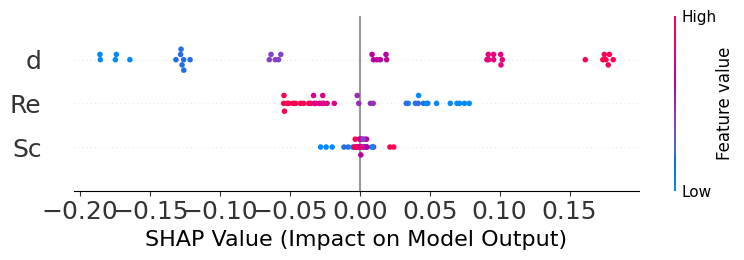


SHAP Explanation for U:


  0%|          | 0/38 [00:00<?, ?it/s]

The figure layout has changed to tight


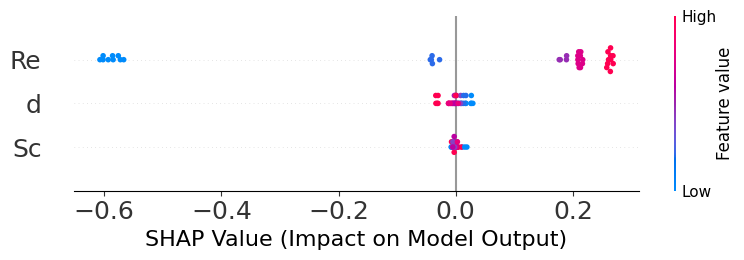


SHAP Explanation for E:


  0%|          | 0/38 [00:00<?, ?it/s]

The figure layout has changed to tight


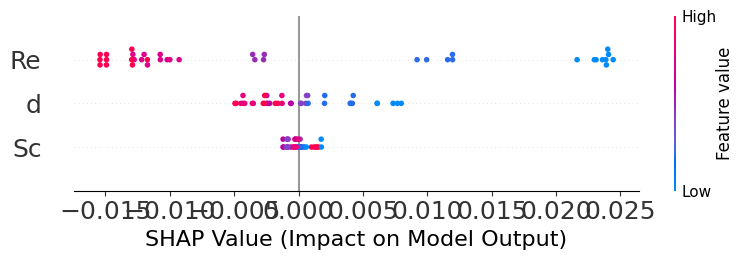

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import numpy as np

# Function to evaluate model metrics
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, r2, rmse

# Function to visualize SHAP values for MLP
def shap_explanation_plot_svr(svr_rbf, X_test, features_list, output_filename="shap_plot.eps"):
    # Use DeepExplainer for neural network models like MLP
    explainer = shap.KernelExplainer(svr_rbf.predict, X_test)
    shap_values = explainer.shap_values(X_test)

    # Visualize global importance with increased font size
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=features_list, show=False)
    plt.title('', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('SHAP Value (Impact on Model Output)', fontsize=16)
    
    # Save the plot as an EPS file
    plt.tight_layout()
    plt.savefig(output_filename, format='eps')
    plt.show()
    plt.close()

    # Visualize individual prediction explanation
    #shap.force_plot(explainer.expected_value[0], shap_values[0], X_test[0], feature_names=features_list)

# Extract predictions and models from svr evaluation
y_pred_C = metrics_C[5]
y_pred_U = metrics_U[5]
y_pred_E = metrics_E[5]

svr_rbf_C = metrics_C[6]
svr_rbf_U = metrics_U[6]
svr_rbf_E = metrics_E[6]

# Visualize SHAP values for each target using MLP
print("\nSHAP Explanation for C:")
shap_explanation_plot_svr(svr_rbf_C, X_test, features_list, "shap_C.eps")

print("\nSHAP Explanation for U:")
shap_explanation_plot_svr(svr_rbf_U, X_test, features_list, "shap_U.eps")

print("\nSHAP Explanation for E:")
shap_explanation_plot_svr(svr_rbf_E, X_test, features_list, "shap_E.eps")



Permutation Importance for C:


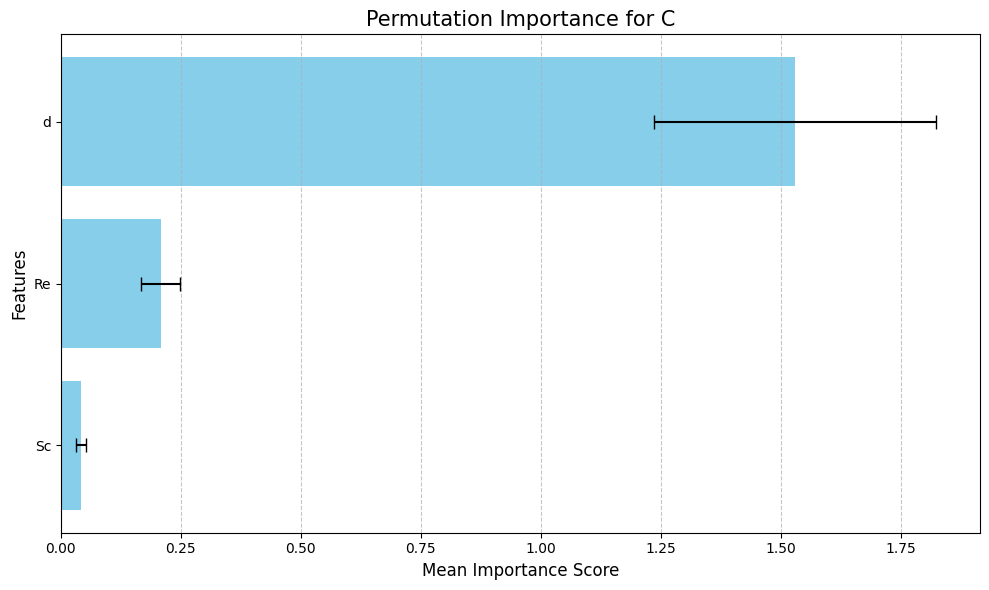


Permutation Importance for U:


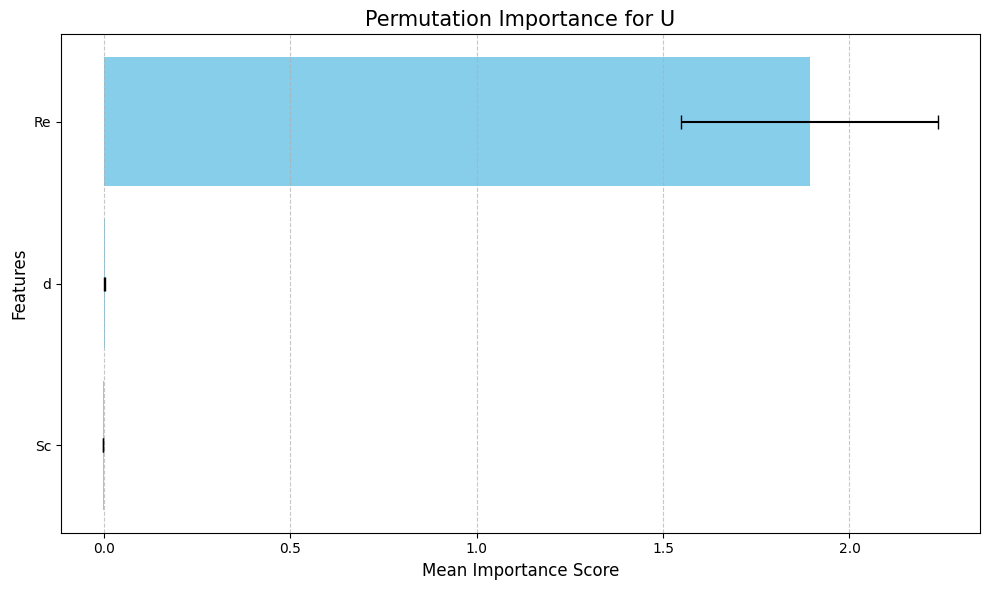


Permutation Importance for E:


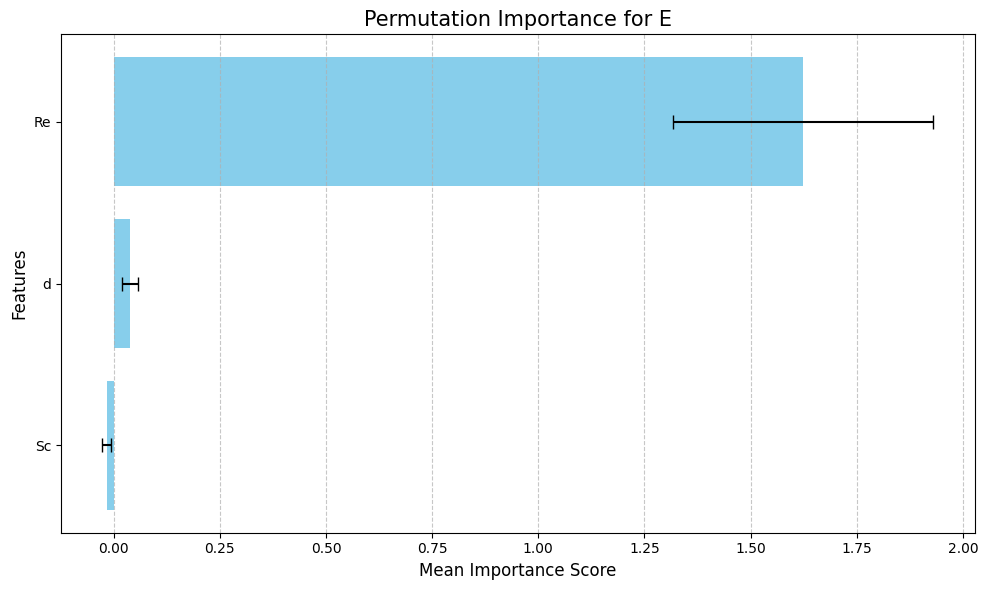

In [6]:
from sklearn.inspection import permutation_importance
import matplotlib.cm as cm

# Generate a colormap
#colors = cm.viridis(np.linspace(0, 1, len(sorted_idx)))  # 'viridis' is an example, choose any colormap

# Function to compute and plot permutation importance
def plot_permutation_importance(svr_rbf, X_test, y_test, feature_names, target_name):
    # Calculate permutation importance
    perm_importance = permutation_importance(svr_rbf, X_test, y_test, n_repeats=30, random_state=42)

    # Extract importance values and sort by descending order
    sorted_idx = perm_importance.importances_mean.argsort()
    importance_mean = perm_importance.importances_mean[sorted_idx]
    importance_std = perm_importance.importances_std[sorted_idx]
    features_sorted = [feature_names[i] for i in sorted_idx]

    # Create a bar plot for permutation importance
    plt.figure(figsize=(10, 6))
    plt.barh(features_sorted, importance_mean, xerr=importance_std, color='skyblue', ecolor='black', capsize=5)
    plt.xlabel('Mean Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title(f'Permutation Importance for {target_name}', fontsize=15)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Apply permutation importance for each target
print("\nPermutation Importance for C:")
plot_permutation_importance(metrics_C[6], X_test, y_test_C, features_list, "C")

print("\nPermutation Importance for U:")
plot_permutation_importance(metrics_U[6], X_test, y_test_U, features_list, "U")

print("\nPermutation Importance for E:")
plot_permutation_importance(metrics_E[6], X_test, y_test_E, features_list, "E")


color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


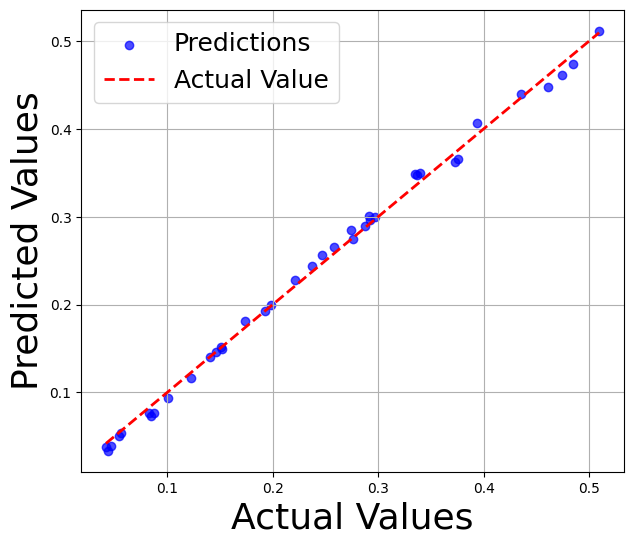

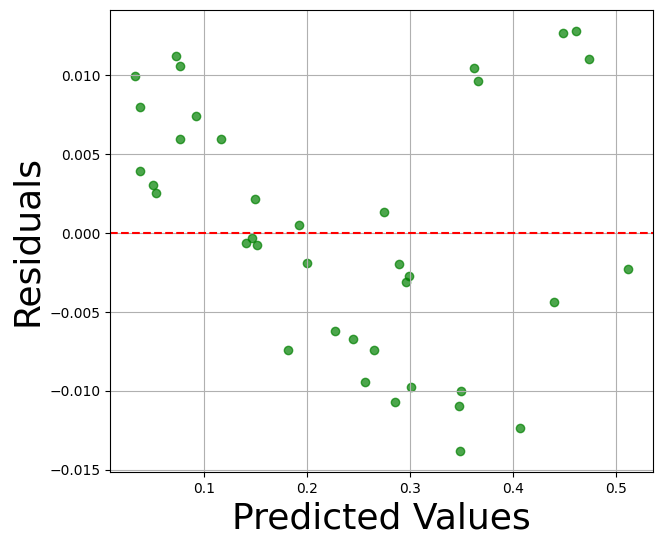

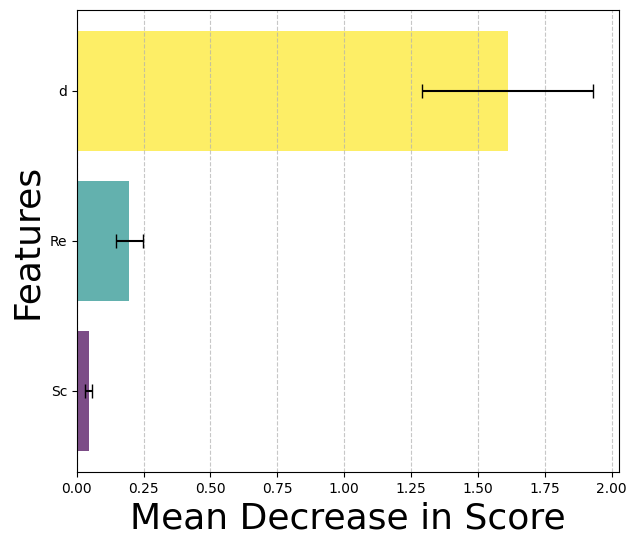

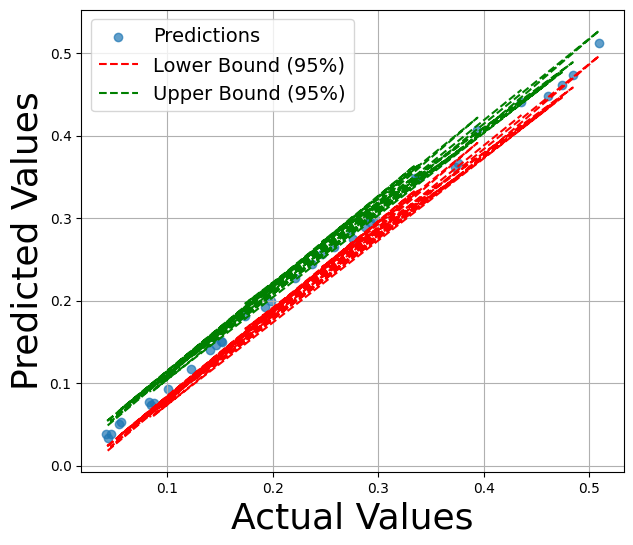

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


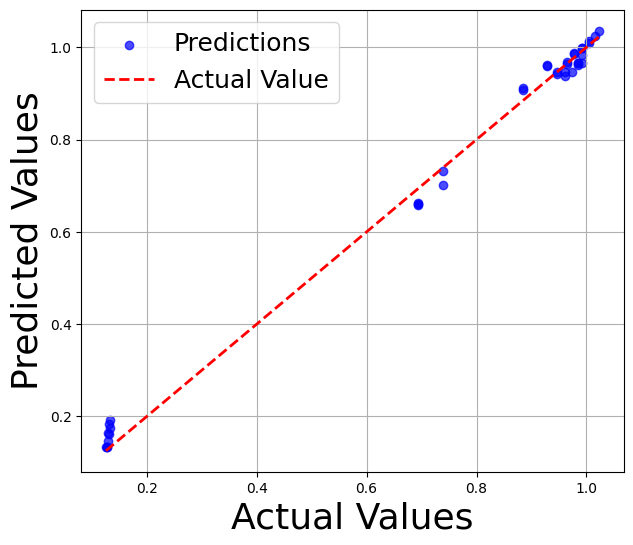

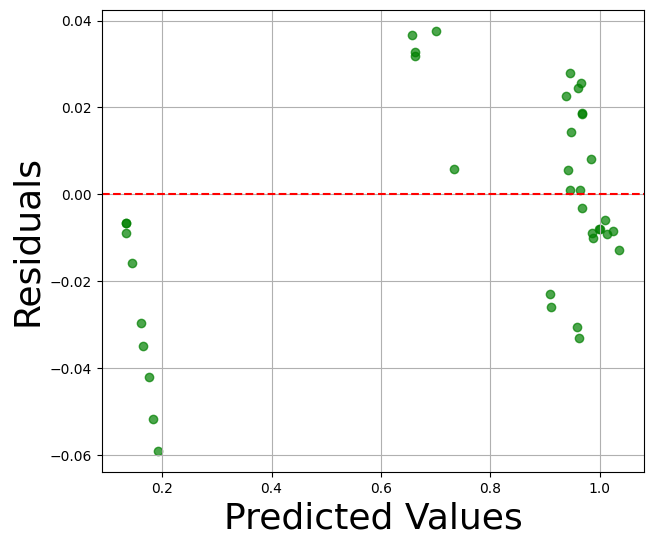

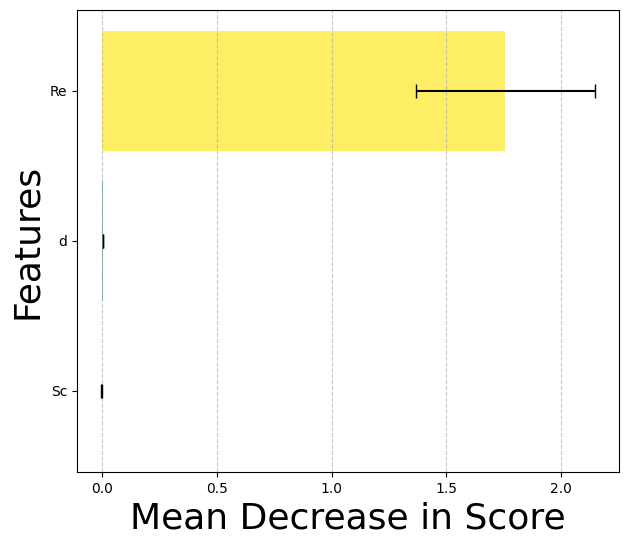

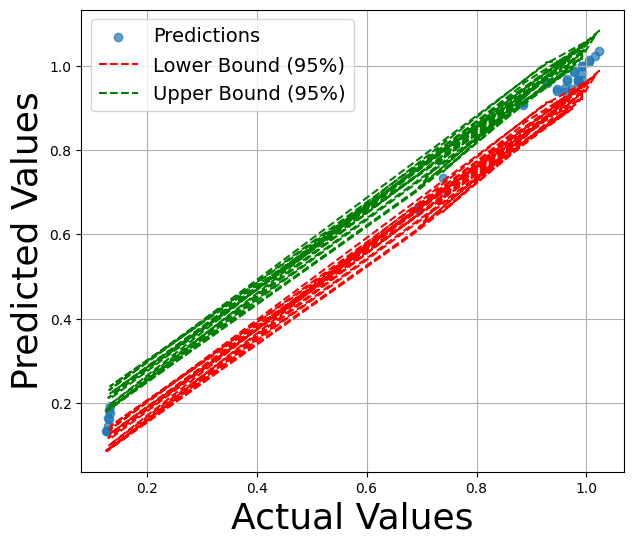

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.


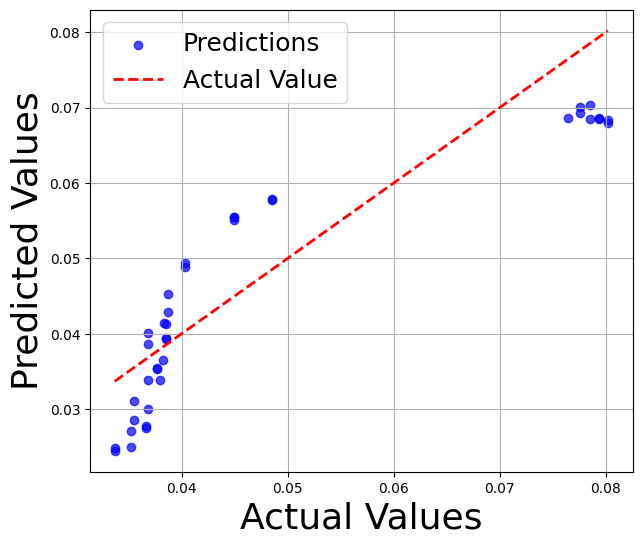

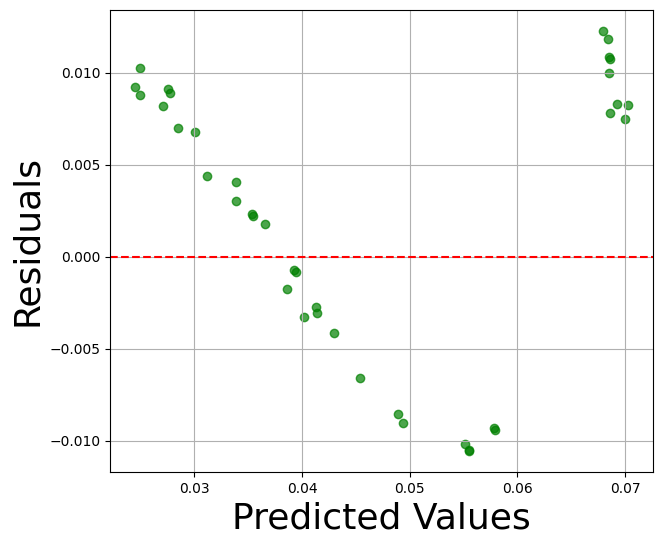

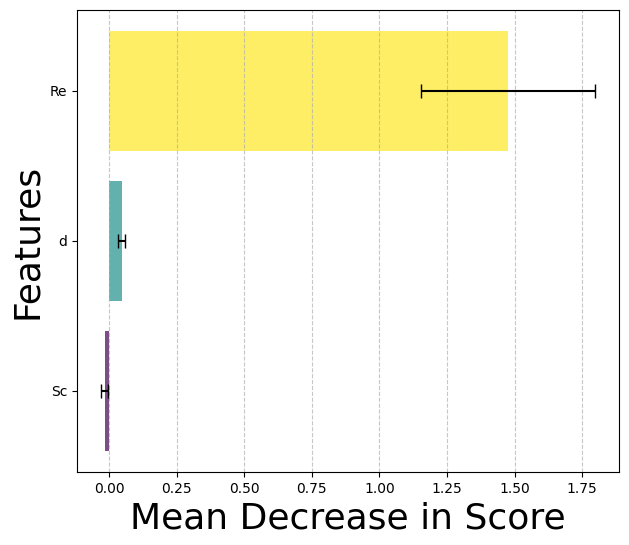

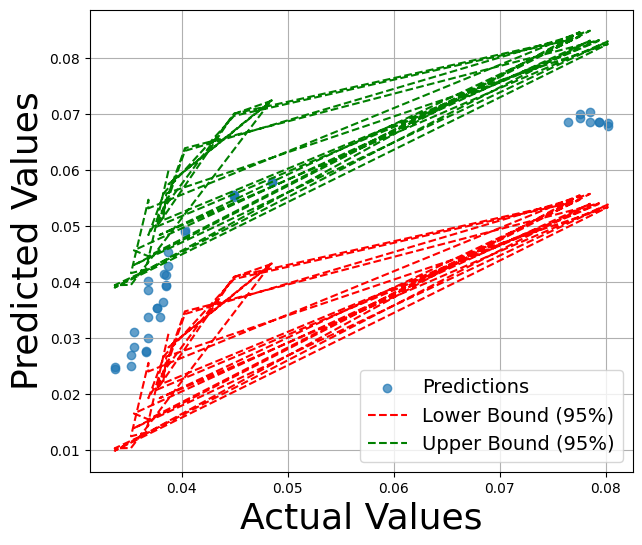

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.inspection import permutation_importance
import matplotlib.cm as cm

# Function to generate and save evaluation plots separately
def plot_evaluation_metrics(y_test, y_pred, svr_rbf, X_test, target_name, interval=1.96):
    residuals = y_test - y_pred
    fontsize = 26  

    # 1. Predicted vs Actual
    fig_pred_actual, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Predictions')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red', label='Actual Value')
    ax.set_xlabel('Actual Values', fontsize=fontsize)
    ax.set_ylabel('Predicted Values', fontsize=fontsize)
    ax.legend(loc='upper left', fontsize=fontsize-8)
    ax.grid(True)
    fig_pred_actual.savefig(f'Predicted_vs_Actual_{target_name}.png', format='png', dpi=300)
    plt.show()
    plt.close(fig_pred_actual)

    # 2. Residual Plot
    fig_residuals, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_pred, residuals, color='green', alpha=0.7)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values', fontsize=fontsize)
    ax.set_ylabel('Residuals', fontsize=fontsize)
    ax.grid(True)
    fig_residuals.savefig(f'Residuals_{target_name}.png', format='png', dpi=300)
    plt.show()
    plt.close(fig_residuals)

    # 3. Feature Importance (Permutation Importance)
    perm_importance = permutation_importance(svr_rbf, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()
    colors = cm.viridis(np.linspace(0, 1, len(sorted_idx)))

    fig_importance, ax = plt.subplots(figsize=(7, 6))
    ax.barh(range(len(sorted_idx)), 
            perm_importance.importances_mean[sorted_idx], 
            xerr=perm_importance.importances_std[sorted_idx], 
            color=colors, ecolor='black', capsize=5, alpha=0.7)
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([features_list[i] for i in sorted_idx])
    ax.set_xlabel('Mean Decrease in Score', fontsize=fontsize)
    ax.set_ylabel('Features', fontsize=fontsize)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    fig_importance.savefig(f'Feature_Importance_{target_name}.png', format='png', dpi=300)
    plt.show()
    plt.close(fig_importance)

    # 4. Prediction Intervals
    std_pred = np.std(residuals)
    lower_bound = y_pred - interval * std_pred
    upper_bound = y_pred + interval * std_pred

    fig_intervals, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(y_test, y_pred, label='Predictions', alpha=0.7)
    ax.plot(y_test, lower_bound, 'r--', label='Lower Bound (95%)')
    ax.plot(y_test, upper_bound, 'g--', label='Upper Bound (95%)')
    ax.set_xlabel('Actual Values', fontsize=fontsize)
    ax.set_ylabel('Predicted Values', fontsize=fontsize)
    ax.legend(fontsize=fontsize-12)
    ax.grid(True)
    fig_intervals.savefig(f'Prediction_Intervals_{target_name}.png', format='png', dpi=300)
    plt.show()
    plt.close(fig_intervals)

# Example calls
plot_evaluation_metrics(y_test_C, metrics_C[5], svr_rbf_C, X_test, "C")
plot_evaluation_metrics(y_test_U, metrics_U[5], svr_rbf_U, X_test, "U")
plot_evaluation_metrics(y_test_E, metrics_E[5], svr_rbf_E, X_test, "E")



Results for C:


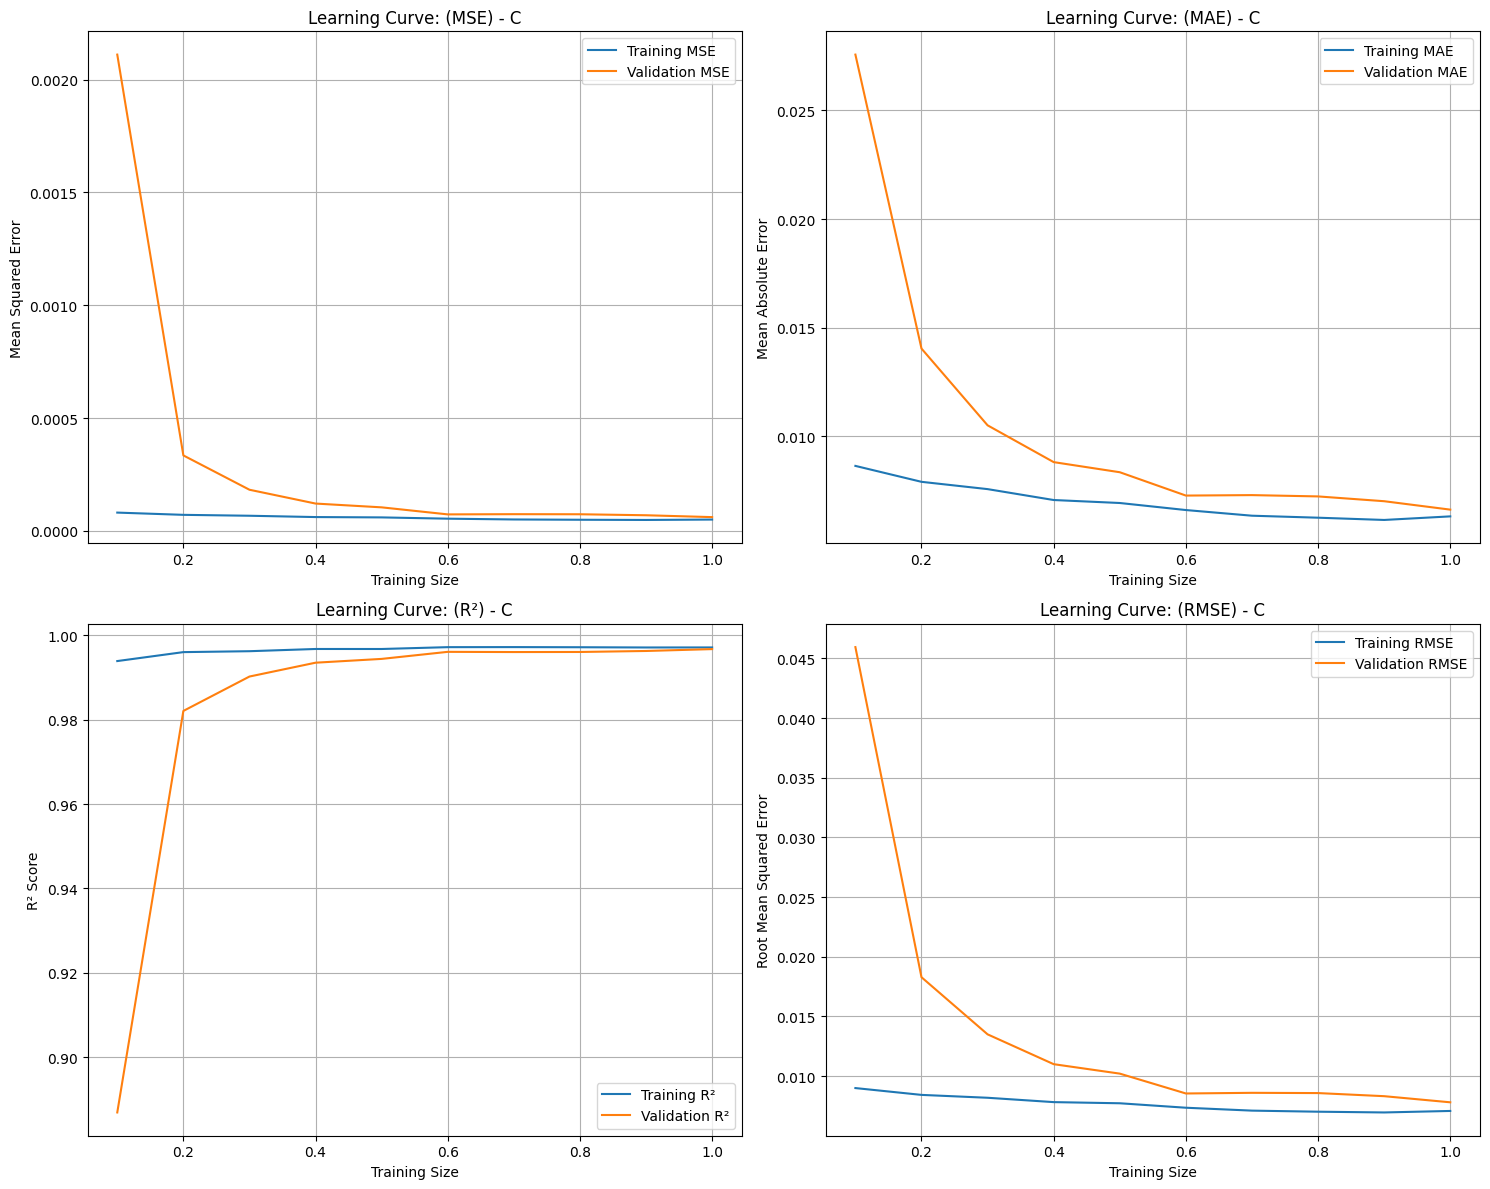


Results for U:


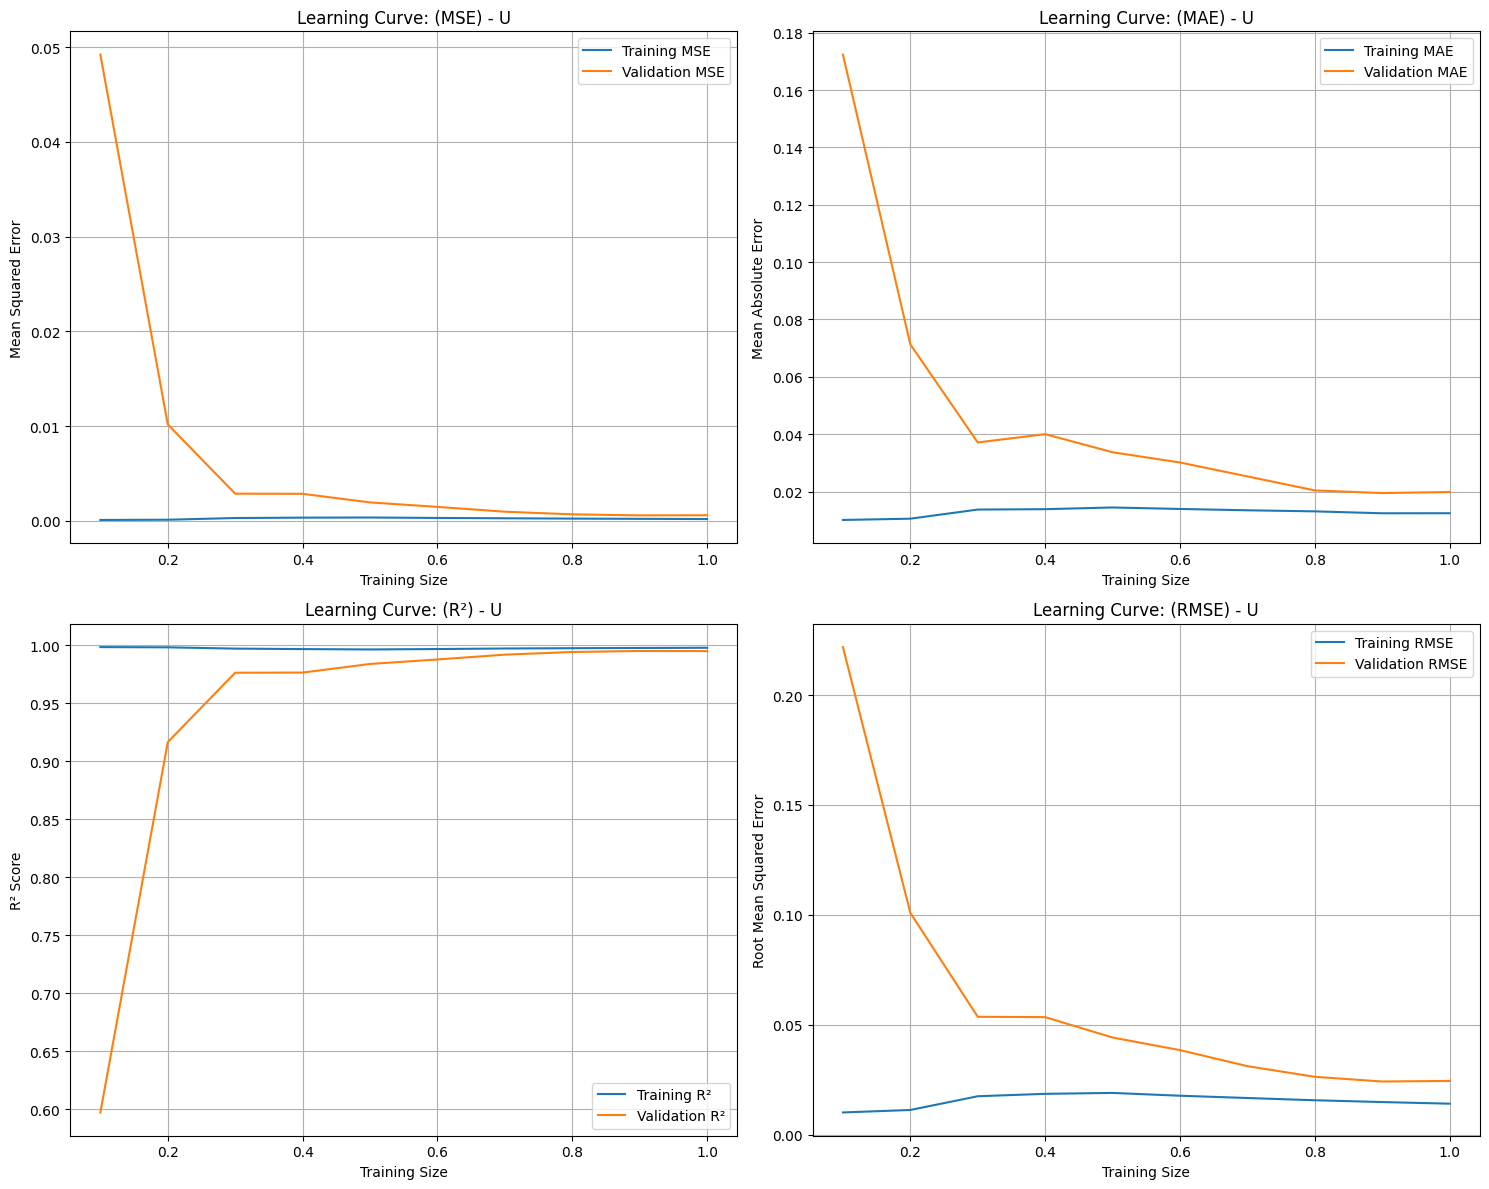


Results for E:


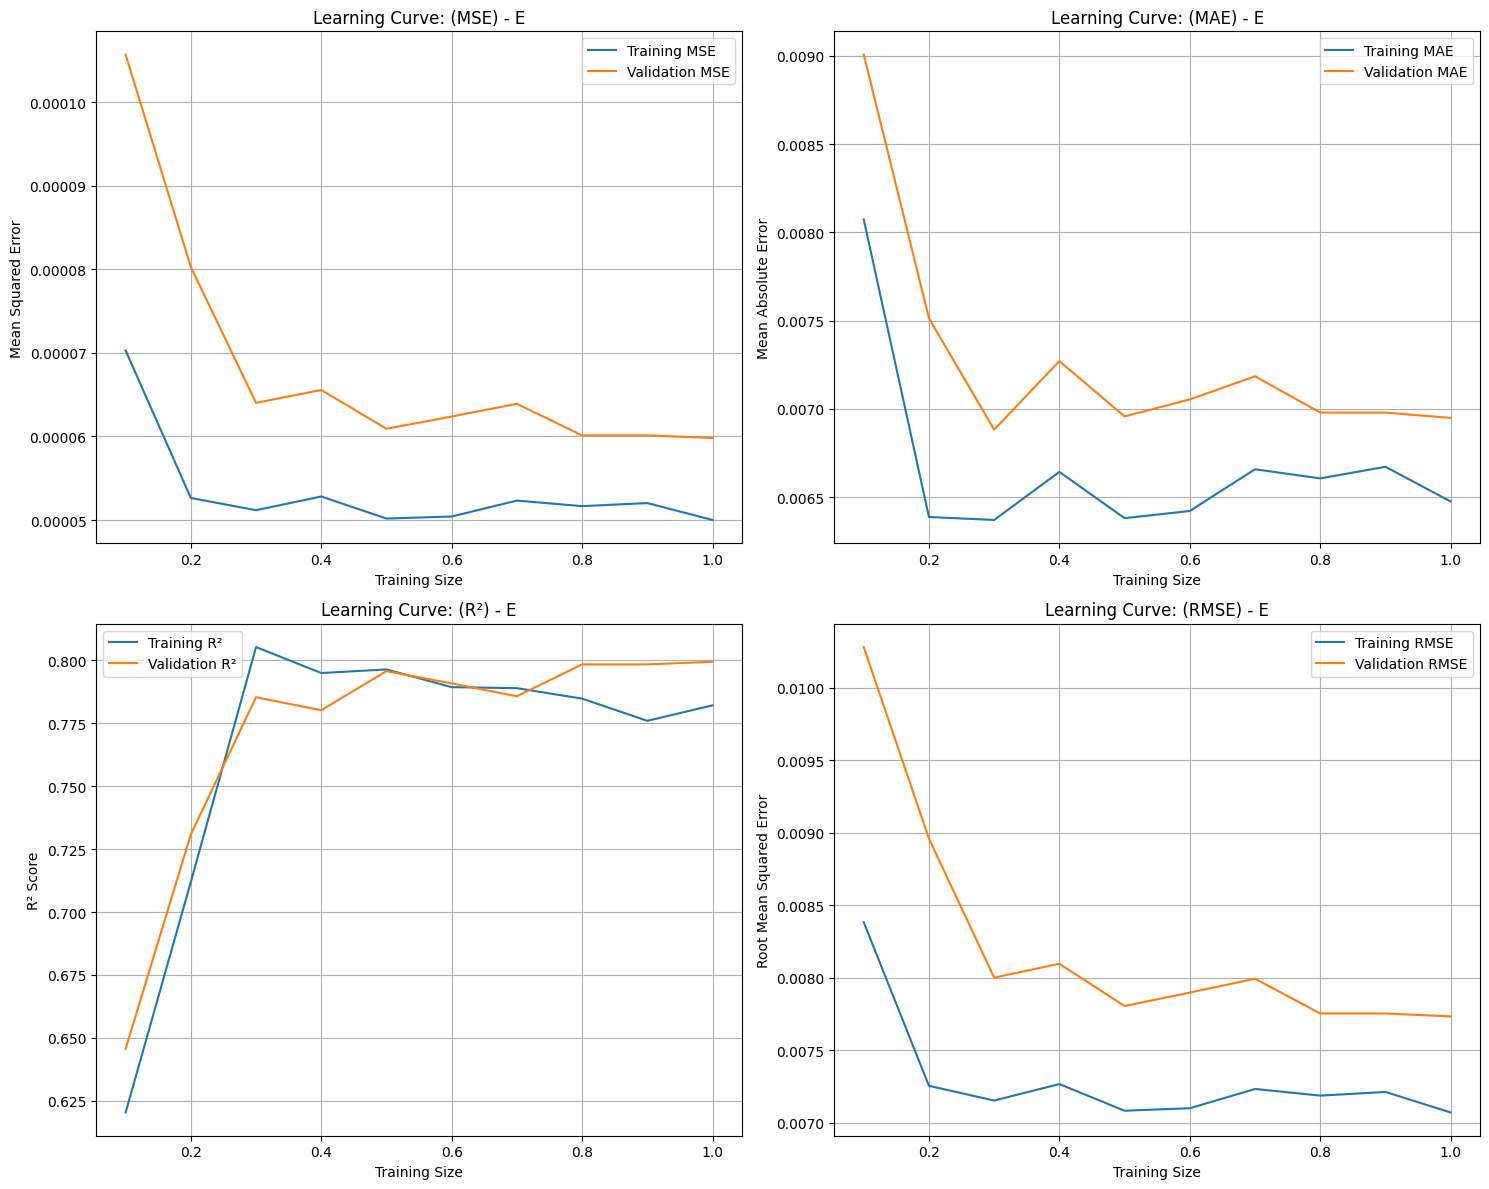

In [8]:
def plot_learning_curves(svr_rbf, X_train, X_test, y_train, y_test, target_name):
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    mse_train, mse_test = [], []
    mae_train, mae_test = [], []
    r2_train, r2_test = [], []
    rmse_train, rmse_test = [], []
    
    for train_size in train_sizes:
        X_train_subset = X_train[:int(train_size * len(X_train))]
        y_train_subset = y_train[:int(train_size * len(y_train))]
        
        # Train model on subset
        svr_rbf.fit(X_train_subset, y_train_subset)
        
        # Predict on both train and test sets
        train_pred = svr_rbf.predict(X_train_subset)
        test_pred = svr_rbf.predict(X_test)
        
        # Calculate metrics
        mse_train.append(mean_squared_error(y_train_subset, train_pred))
        mse_test.append(mean_squared_error(y_test, test_pred))
        
        mae_train.append(mean_absolute_error(y_train_subset, train_pred))
        mae_test.append(mean_absolute_error(y_test, test_pred))
        
        r2_train.append(r2_score(y_train_subset, train_pred))
        r2_test.append(r2_score(y_test, test_pred))
        
        rmse_train.append(np.sqrt(mse_train[-1]))
        rmse_test.append(np.sqrt(mse_test[-1]))
    
    # Plotting learning curves for MSE, MAE, R², RMSE
    plt.figure(figsize=(15, 12))
    
    # MSE Learning Curve
    plt.subplot(2, 2, 1)
    plt.plot(train_sizes, mse_train, label='Training MSE')
    plt.plot(train_sizes, mse_test, label='Validation MSE')
    plt.title(f"Learning Curve: (MSE) - {target_name}")
    plt.xlabel("Training Size")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid()

    # MAE Learning Curve
    plt.subplot(2, 2, 2)
    plt.plot(train_sizes, mae_train, label='Training MAE')
    plt.plot(train_sizes, mae_test, label='Validation MAE')
    plt.title(f"Learning Curve: (MAE) - {target_name}")
    plt.xlabel("Training Size")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid()

    # R² Learning Curve
    plt.subplot(2, 2, 3)
    plt.plot(train_sizes, r2_train, label='Training R²')
    plt.plot(train_sizes, r2_test, label='Validation R²')
    plt.title(f"Learning Curve: (R²) - {target_name}")
    plt.xlabel("Training Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid()

    # RMSE Learning Curve
    plt.subplot(2, 2, 4)
    plt.plot(train_sizes, rmse_train, label='Training RMSE')
    plt.plot(train_sizes, rmse_test, label='Validation RMSE')
    plt.title(f"Learning Curve: (RMSE) - {target_name}")
    plt.xlabel("Training Size")
    plt.ylabel("Root Mean Squared Error")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Perform XGBoost evaluation for each target and plot learning curves
metrics_C = evaluate_svr(X_train, X_test, y_train_C, y_test_C, "C")
metrics_U = evaluate_svr(X_train, X_test, y_train_U, y_test_U, "U")
metrics_E = evaluate_svr(X_train, X_test, y_train_E, y_test_E, "E")

print("\nResults for C:")
plot_learning_curves(metrics_C[6], X_train, X_test, y_train_C, y_test_C, "C")

print("\nResults for U:")
plot_learning_curves(metrics_U[6], X_train, X_test, y_train_U, y_test_U, "U")

print("\nResults for E:")
plot_learning_curves(metrics_E[6], X_train, X_test, y_train_E, y_test_E, "E")


In [9]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import r2_score

# Function to perform OLS regression for each target
def evaluate_ols(X_train, y_train, X_test, y_test, target_name, features):
    # Add constant term for OLS model (this is the intercept)
    X_train_ols = sm.add_constant(X_train, has_constant='add')
    X_test_ols = sm.add_constant(X_test, has_constant='add')

    # Assign feature names after adding constant term
    feature_names = ['const'] + features
    X_train_ols = pd.DataFrame(X_train_ols, columns=feature_names)
    X_test_ols = pd.DataFrame(X_test_ols, columns=feature_names)

    # Reset the index of y_train to align it with X_train
    y_train_ols = y_train.reset_index(drop=True)

    # Fit OLS model
    model = sm.OLS(y_train_ols, X_train_ols).fit()

    # Print the summary to verify feature names and coefficients
    print(f"\nOLS Regression Results for {target_name}:")
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X_test_ols)

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score for {target_name}: {r2:.4f}")
    
    return r2, y_pred, model

# Assuming 'df' is your dataset and features are ['n', 'g', 'Re']
features = ['Re', 'd', 'Sc']

# Define the targets you want to predict
targets = ['C', 'U', 'E']

# Assuming you have already split your data into X_train, X_test, y_train, and y_test
# Example: for 'Avg Nu' target
y_train_C = y_train['C']
y_test_C = y_test['C']

y_train_U = y_train['U']
y_test_U = y_test['U']

y_train_E = y_train['E']
y_test_E = y_test['E']

# Evaluate OLS for each target (Avg Nu, Drag, Lift)
ols_results_C = evaluate_ols(X_train, y_train_C, X_test, y_test_C, "C", features)
ols_results_U = evaluate_ols(X_train, y_train_U, X_test, y_test_U, "U", features)
ols_results_E = evaluate_ols(X_train, y_train_E, X_test, y_test_E, "E", features)



OLS Regression Results for C:
                            OLS Regression Results                            
Dep. Variable:                      C   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     1584.
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          5.13e-110
Time:                        17:28:31   Log-Likelihood:                 350.39
No. Observations:                 148   AIC:                            -692.8
Df Residuals:                     144   BIC:                            -680.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2300